<a href="https://colab.research.google.com/github/yukanaya24/project-1_cvbasic/blob/tanaka/optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# On how to train and test a deep neural network for the super-resolution task.
> Prepared by Man M. Ho


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/共有/cvbasic_project"

/content/drive/MyDrive/共有/cvbasic_project


# ライブラリのインポート

In [ ]:
!pip install pytorch-msssim lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# For Path Processing
from os.path import exists, join, basename
from os import makedirs, remove, getcwd, listdir

# To download and extract datasets
from six.moves import urllib
import tarfile

# For Datasets and Transformation
from PIL import Image
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

# For Network Architecture
import torch
import torch.nn as nn
import torch.nn.init as init

# PyTorch Optimizer
import torch.optim as optim

# Others
import numpy as np
from math import log10
import matplotlib.pyplot as plt # For plotting

from pytorch_msssim import ms_ssim
import lpips as lpips_lib


from typing import Optional, Union, Tuple, List

# データの準備とデータセット

In [ ]:
def download_bsds300(dest: str = "dataset") -> None:
    current_dir: str = getcwd()
    output_image_dir: str = join(current_dir, dest, "BSDS300/images")

    if not exists(output_image_dir):
        makedirs(dest)
        url: str = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("Downloading Dataset at ", url)

        data: urllib.request.addinfourl = urllib.request.urlopen(url)

        file_path: str = join(dest, basename(url))
        with open(file_path, 'wb') as f:
            f.write(data.read())

        print("Extracting Data")
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)
    print('Done! Extracted Dataset is saved at : ' + join(output_image_dir))

In [ ]:
download_bsds300()

Done! Extracted Dataset is saved at : /content/drive/MyDrive/共有/cvbasic_project/dataset/BSDS300/images


### データローダの準備

In [ ]:
def is_image_file(filename: str) -> bool:  # 拡張子の確認
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


# PIL.Image を使用し画像を読込、RGB -> YCbCr に変換
# Y は輝度/グレースケール成分、Cb と CR は彩度/カラー成分 (この作業では、Y のみをアップサンプリング)
def load_img(filepath: str) -> Image.Image:
    img: Image.Image = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()   # Y, Cb, Crに分割しYチャネルのみを返す
    return y


class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir: str,
                 input_transform: Optional[Compose] = None,
                 target_transform: Optional[Compose] = None) -> None:
        super(DatasetFromFolder, self).__init__()
        self.image_filenames: List[str] = [
            join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)
        ]

        self.input_transform: Optional[Compose] = input_transform
        self.target_transform: Optional[Compose] = target_transform


    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        # 画像の読み込み
        input: Image.Image = load_img(self.image_filenames[index])
        target: Image.Image = input.copy()

        # 入力画像のサイズを 1/scale に変換
        if self.input_transform:
            input = self.input_transform(input)

        # target は原画像
        if self.target_transform:
            target = self.target_transform(target)

        return input, target


    def __len__(self) -> int:
        return len(self.image_filenames)


# upscale_factor に適した crop_size の結果
def calculate_valid_crop_size(crop_size: int, upscale_factor: int) -> int:
    return crop_size - (crop_size % upscale_factor)


def input_transform(crop_size: int, upscale_factor: int) -> Compose:
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        ToTensor(),
    ])


def target_transform(crop_size: int) -> Compose:
    return Compose([
        CenterCrop(crop_size),
        ToTensor(),
    ])


# train 用 Pytorch dataset
def get_training_set(root_dir: str, upscale_factor: int) -> DatasetFromFolder:
    train_dir: str = join(root_dir, "train")
    crop_size: int = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(train_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

# test 用 Pytorch dataset
def get_test_set(root_dir, upscale_factor) -> DatasetFromFolder:
    test_dir: str = join(root_dir, "test")
    crop_size: int = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))


# ネットワーク構造
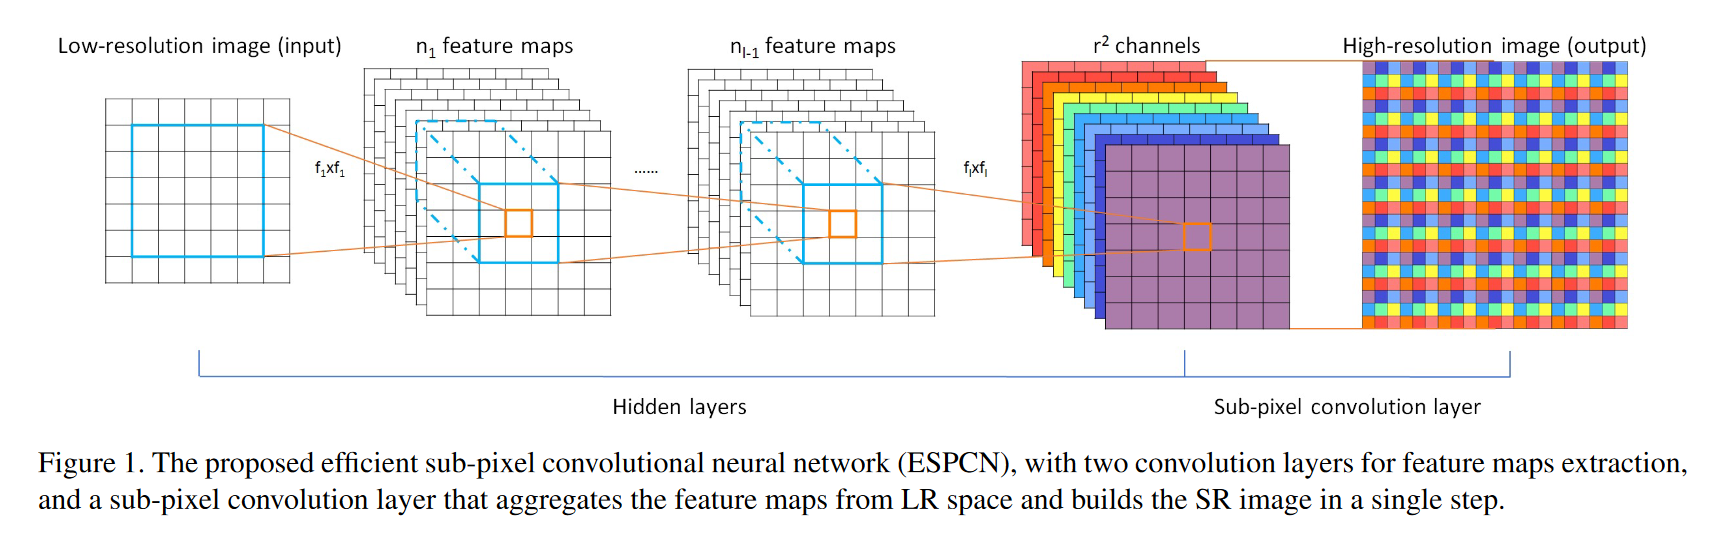

ネットワークアーキテクチャについては、$N$層の畳み込み層（コードでは$N$=4に設定）を持つEfficient Sub-Pixel Convolutional Neural Network (ESPCN、https://arxiv.org/pdf/1609.05158.pdf
) を採用しています。推論順序における特徴量サイズは以下のとおりです。:

---
Input Y:

> $H \times W \times 1$

---
Conv1 x ReLU:

> $H \times W \times 1 \rightarrow H \times W \times 64$

---
Conv2 x ReLU:

> $H \times W \times 64 \rightarrow H \times W \times 64$

---
Conv3 x ReLU:

> $H \times W \times 64 \rightarrow H \times W \times 32$

---
Conv4:

> $H \times W \times 32 \rightarrow H \times W \times (upscale\_factor ** 2)$

---
Pixel_Shuffle:

> $H \times W \times (upscale_factor ** 2) \rightarrow H' \times W' \times 1

where:

> $H' = H * upscale_factor$
>
> W' = W * upscale_factor

ピクセルシャッフル技術は、
$H x W x (upscale\_factor**2)$  
の特徴マップを高解像度の出力画像 H' x W' x 1 に変換します。

---

In [ ]:
class Net(nn.Module):
    def __init__(self, upscale_factor: int) -> None:
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))

        return x


    def _initialize_weights(self) -> None:
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)


# Train Models

## ハイパーパラメータの設定

In [ ]:
args: dict[str, Union[str, int, float]] = {}

# BSD300データセットが保存される場所
args['root_dir'] = './dataset/BSDS300/images'

# 超解像度アップスケール係数
args['upscale_factor'] = 2

# training batch size
args['batchSize'] = 64

# testing batch size
args['testBatchSize'] = 10

# トレーニングするエポック数
args['nEpochs'] = 50

# 学習率
args['lr'] = 0.01

# データローダーが使用するスレッド数
args['threads'] = 4

# シード
args['seed'] = 42

In [ ]:
torch.manual_seed(args['seed'])

## train と test のデータローダーを宣言

In [ ]:
train_set = get_training_set(args['root_dir'], args['upscale_factor'])
test_set = get_test_set(args['root_dir'], args['upscale_factor'])

training_data_loader = DataLoader(
    dataset = train_set,
    num_workers = args['threads'],
    batch_size = args['batchSize'],
    shuffle = True
)
testing_data_loader = DataLoader(
    dataset = test_set,
    num_workers = args['threads'],
    batch_size = args['testBatchSize'],
    shuffle = False
)

## モデルと基準の宣言

In [ ]:
model = Net(upscale_factor=args['upscale_factor']).cuda()
training_loss_fn = nn.MSELoss()
mse_fn = nn.MSELoss()

## optimizer の宣言

Adam: https://arxiv.org/abs/1412.6980

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

## Train 関数

In [ ]:
def train(epoch: int) -> float:
    print('Epoch: {}'.format(epoch))
    epoch_loss: float = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        input: torch.Tensor = batch[0].cuda()
        target: torch.Tensor = batch[1].cuda()

        optimizer.zero_grad()
        loss: torch.Tensor = training_loss_fn(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        # print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Train: Avg. Loss:  {:.4f}".format(epoch_loss / len(training_data_loader)))
    return epoch_loss / len(training_data_loader)

## Test 関数

In [ ]:
def test() -> float:
    avg_psnr: float = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input: torch.Tensor = batch[0].cuda()
            target: torch.Tensor = batch[1].cuda()

            prediction: torch.Tensor = model(input)
            mse: torch.Tensor = mse_fn(prediction, target)
            psnr: float = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Test : Avg. PSNR: {:.4f} dB\n".format(avg_psnr / len(testing_data_loader)))
    return avg_psnr / len(testing_data_loader)

## チェックポイントの保存

In [ ]:
def save_checkpoint(epoch: int, model_name: str = 'model') -> None:
    model_out_path: str = model_name + "_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

## モデルの学習

- BSDS300 dataset
- 損失関数 : MSE
- 畳み込み層 : 4層

Epoch: 1
===> Train: Avg. Loss:  3.3200
===> Test : Avg. PSNR: 6.0919 dB

Epoch: 2
===> Train: Avg. Loss:  0.1957
===> Test : Avg. PSNR: 10.3416 dB

Epoch: 3
===> Train: Avg. Loss:  0.0640
===> Test : Avg. PSNR: 13.1920 dB

Epoch: 4
===> Train: Avg. Loss:  0.0338
===> Test : Avg. PSNR: 13.2377 dB

Epoch: 5
===> Train: Avg. Loss:  0.0405
===> Test : Avg. PSNR: 15.8670 dB

Epoch: 6
===> Train: Avg. Loss:  0.0266
===> Test : Avg. PSNR: 15.1413 dB

Epoch: 7
===> Train: Avg. Loss:  0.0225
===> Test : Avg. PSNR: 16.0689 dB

Epoch: 8
===> Train: Avg. Loss:  0.0219
===> Test : Avg. PSNR: 17.2865 dB

Epoch: 9
===> Train: Avg. Loss:  0.0184
===> Test : Avg. PSNR: 17.4027 dB

Epoch: 10
===> Train: Avg. Loss:  0.0170
===> Test : Avg. PSNR: 17.8125 dB

Epoch: 11
===> Train: Avg. Loss:  0.0153
===> Test : Avg. PSNR: 18.2008 dB

Epoch: 12
===> Train: Avg. Loss:  0.0140
===> Test : Avg. PSNR: 18.6444 dB

Epoch: 13
===> Train: Avg. Loss:  0.0129
===> Test : Avg. PSNR: 18.8829 dB

Epoch: 14
===> Train: 

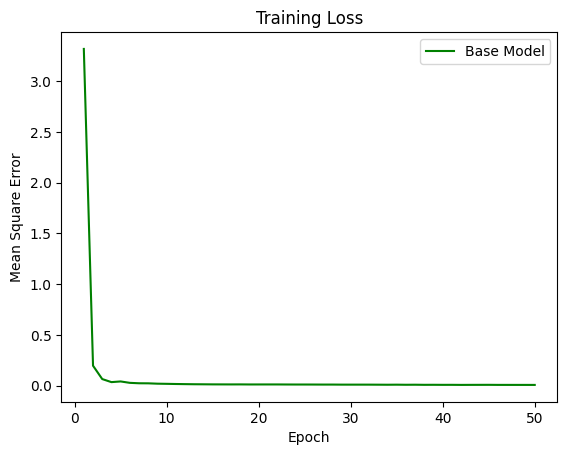

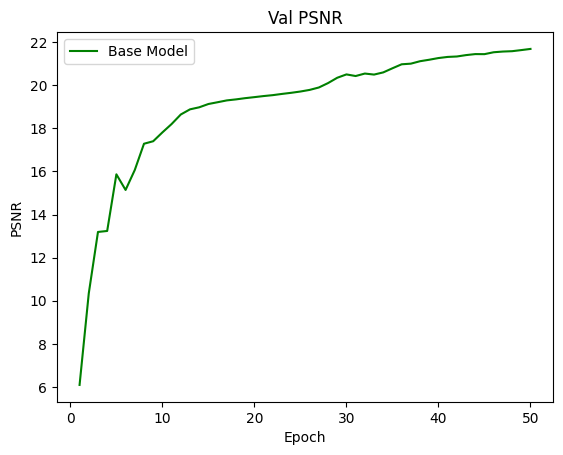

In [ ]:
base_train_errors: list[float] = []
base_test_psnrs: list[float] = []
for epoch in range(1, args['nEpochs'] + 1):
    train_error: float = train(epoch)
    test_psnr: float = test()
    base_train_errors.append(train_error)
    base_test_psnrs.append(test_psnr)

save_checkpoint(args['nEpochs'], model_name='model_base')


# Plotting errors
## Note for plot function, Args from left to right:
### range,
### list of values,
### color such as 'g' -> green, 'b' --> blue, 'r' --> red
#### See more colors here https://matplotlib.org/stable/gallery/color/named_colors.html
### label
plt.figure()
plt.plot(range(1, args['nEpochs'] + 1), base_train_errors, 'g', label='Base Model')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, args['nEpochs'] + 1), base_test_psnrs, 'g', label='Base Model')

plt.title('Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()

# Tasks
Task 1. 学習済みモデルを用いて、1枚の画像に対するテスト結果を確認する（20点）

Task 2. 損失関数に関するアブレーションスタディを実施する。各損失関数を用いた際のモデル性能（PSNR）を比較する。（30点）

Task 3. ネットワーク構造やハイパーパラメータなどを調整し、性能（PSNR）の向上を図る（50点）

上記に示したトレーニング損失や検証時のPSNRのプロット方法を参考にしてください。


##Task 1. Test the trained model on your own images

The run function is as:

In [ ]:
def run_model(
    input_image:str , output_filename: str, model_path: str
) -> Tuple[Image.Image, Image.Image]:

    img: Image.Image = Image.open(input_image).convert('YCbCr')
    y, cb, cr = img.split()

    model: Net = torch.load(model_path, weights_only=False)
    img_to_tensor: ToTensor = ToTensor()
    input: torch.Tensor = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])

    model = model.cuda()
    input = input.cuda()

    out: torch.Tensor = model(input)
    out = out.cpu()

    out_img_y: np.ndarray = out[0].detach().numpy()
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

    out_img_cb: Image.Image = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr: Image.Image = cr.resize(out_img_y.size, Image.BICUBIC)

    out_img: Image.Image = Image.merge(
       'YCbCr', [out_img_y, out_img_cb, out_img_cr]
    ).convert('RGB')

    out_img.save(output_filename)
    print('Output image saved to ', output_filename)
    return img.convert('RGB'), out_img

In [ ]:
# An example
input_image: str = "./dataset/BSDS300/images/test/101085.jpg"
output_filename: str = "101085_x2.jpg"

model_path: str = "model_base_epoch_50.pth"
img, out_img = run_model(input_image, output_filename, model_path)

Output image saved to  101085_x2.jpg


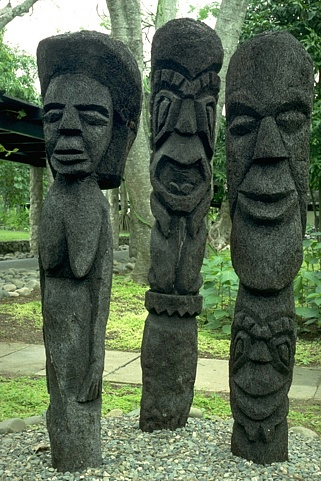

In [ ]:
img

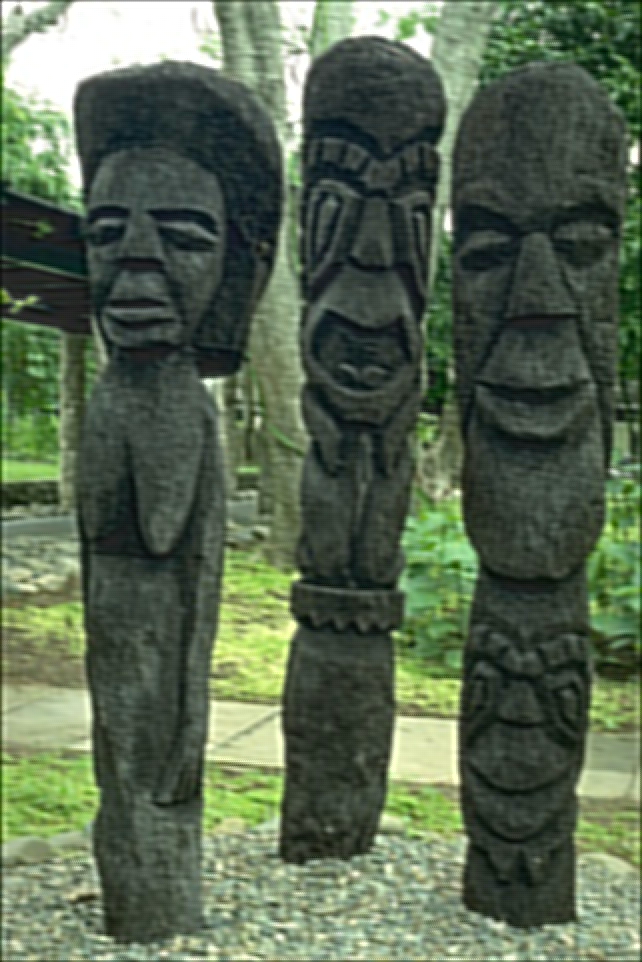

In [ ]:
out_img

##Task 2. Conduct an ablation study on loss function.
損失関数に関して ablation study を行う

MSE（Mean Square Error：平均二乗誤差）以外にも、画像生成に用いられる損失関数は多数存在します。以下はその一部です：

> [L1](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss)
 /
[L1 Smooth](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html#torch.nn.SmoothL1Loss)
 /
[Huber Loss](https://pytorch.org/docs/stable/generated/torch.nn.HuberLoss.html#torch.nn.HuberLoss)
 /
[MS-SSIM](https://github.com/jorge-pessoa/pytorch-msssim)
 /
[LPIPS](https://github.com/richzhang/PerceptualSimilarity)

MSE以外の損失関数に変更し、結果を分析してください。
以下はL1損失関数に変更する例です。

In [ ]:
# ベースライン. training_loss_fn は変更のためにコメントアウトされています
torch.manual_seed(args['seed'])
model = Net(upscale_factor=args['upscale_factor']).cuda()
# training_loss_fn = nn.MSELoss()
mse_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args['lr'])
train_set = get_training_set(args['root_dir'], args['upscale_factor'])
test_set = get_test_set(args['root_dir'], args['upscale_factor'])
training_data_loader = DataLoader(
    dataset=train_set,
    num_workers=args['threads'],
    batch_size=args['batchSize'],
    shuffle=True
)
testing_data_loader = DataLoader(
    dataset=test_set,
    num_workers=args['threads'],
    batch_size=args['testBatchSize'],
    shuffle=False
)

# 損失関数を変更
loss_fn_name = "HuberLoss" #@param ["MSELoss", "L1Loss", "SmoothL1Loss", "HuberLoss"]

loss_fn = {
    "MSELoss" : nn.MSELoss(),
    "L1Loss" : nn.L1Loss(),
    "SmoothL1Loss" : nn.SmoothL1Loss(),
    "HuberLoss" : nn.HuberLoss(),
    # "MS-SSIM" : ms_ssim,
    # "LPIPS" : lpips
}

training_loss_fn = loss_fn[loss_fn_name]


train_errors = []
test_psnrs = []

for epoch in range(1, args['nEpochs'] + 1):
    train_error: float = train(epoch)
    test_psnr: float = test()
    train_errors.append(train_error)
    test_psnrs.append(test_psnr)

save_checkpoint(args['nEpochs'], model_name='model_l1loss')


Epoch: 1
===> Train: Avg. Loss:  0.7822
===> Test : Avg. PSNR: 6.3319 dB

Epoch: 2
===> Train: Avg. Loss:  0.1022
===> Test : Avg. PSNR: 8.1342 dB

Epoch: 3
===> Train: Avg. Loss:  0.0448
===> Test : Avg. PSNR: 11.1035 dB

Epoch: 4
===> Train: Avg. Loss:  0.0230
===> Test : Avg. PSNR: 15.5427 dB

Epoch: 5
===> Train: Avg. Loss:  0.0161
===> Test : Avg. PSNR: 14.8749 dB

Epoch: 6
===> Train: Avg. Loss:  0.0137
===> Test : Avg. PSNR: 15.5037 dB

Epoch: 7
===> Train: Avg. Loss:  0.0111
===> Test : Avg. PSNR: 17.2027 dB

Epoch: 8
===> Train: Avg. Loss:  0.0078
===> Test : Avg. PSNR: 18.2006 dB

Epoch: 9
===> Train: Avg. Loss:  0.0069
===> Test : Avg. PSNR: 18.1655 dB

Epoch: 10
===> Train: Avg. Loss:  0.0068
===> Test : Avg. PSNR: 19.0582 dB

Epoch: 11
===> Train: Avg. Loss:  0.0054
===> Test : Avg. PSNR: 20.2221 dB

Epoch: 12
===> Train: Avg. Loss:  0.0043
===> Test : Avg. PSNR: 19.9339 dB

Epoch: 13
===> Train: Avg. Loss:  0.0043
===> Test : Avg. PSNR: 20.6864 dB

Epoch: 14
===> Train: A

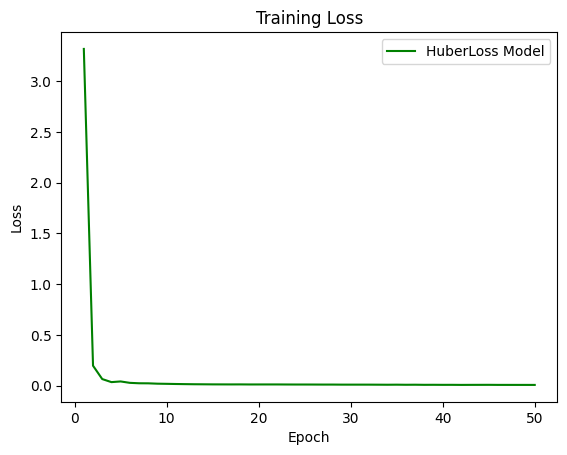

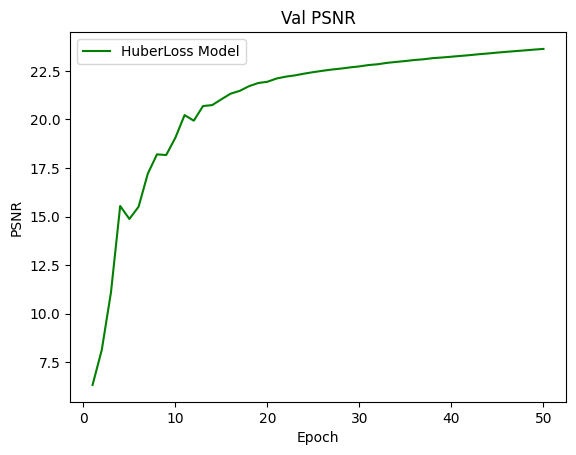

In [ ]:
# 結果のプロット
plt.figure()
plt.plot(
    range(1, args['nEpochs'] + 1),
    base_train_errors,
    'g',
    label=f'{loss_fn_name} Model'
)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(
    range(1, args['nEpochs'] + 1),  # 範囲
    test_psnrs,  # 値のリスト
    'g',  # 色
    label = f'{loss_fn_name} Model'
)
plt.title('Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()

##Task 3 Optimization

###3.1 ハイパーパラメータの調整

In [ ]:
torch.manual_seed(args['seed'])
model = Net(upscale_factor=args['upscale_factor']).cuda()
training_loss_fn = nn.MSELoss()
mse_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args['lr'])
train_set = get_training_set(args['root_dir'], args['upscale_factor'])
test_set = get_test_set(args['root_dir'], args['upscale_factor'])
training_data_loader = DataLoader(
    dataset = train_set,
    num_workers = args['threads'],
    batch_size = args['batchSize'],
    shuffle = True
)
testing_data_loader = DataLoader(
    dataset = test_set,
    num_workers = args['threads'],
    batch_size = args['testBatchSize'],
    shuffle = False
)



args['nEpochs'] = 100

epoch500extend_train_errors: list[float] = []
epoch500extend_test_psnrs: list[float] = []

for epoch in range(1, args['nEpochs'] + 1):
    train_error: float = train(epoch)
    test_psnr: float = test()
    epoch500extend_train_errors.append(train_error)
    epoch500extend_test_psnrs.append(test_psnr)

save_checkpoint(args['nEpochs'], model_name='model_epoch500extend')

## 結果のプロット
l1loss_train_errors = []
l1loss_test_psnrs = []

for epoch in range(1, args['nEpochs'] + 1):
    train_error: float = train(epoch)
    test_psnr: float = test()
    l1loss_train_errors.append(train_error)
    l1loss_test_psnrs.append(test_psnr)

save_checkpoint(args['nEpochs'], model_name='model_l1loss')


plt.figure()
plt.plot(
    range(1, args['nEpochs'] + 1),
    base_train_errors,
    'g',
    label='Base Model'
)

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

plt.figure()
plt.plot(
    range(1, args['nEpochs'] + 1),
    base_test_psnrs,
    'g',
    label='Base Model'
)

plt.title('Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()



RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


###3.2 Change network architecture

ベースラインのネットワーク構造

---
Input Y:  
> $H \times W \times 1$

---
Conv1 x ReLU:

> $H \times W \times 1 \rightarrow H \times W \times 64$

---
Conv2 x ReLU:

> $H \times W \times 64 \rightarrow H \times W \times 64$

---
Conv3 x ReLU:

> $H \times W \times 64 \rightarrow H \times W \times 32$

---
Conv4:

> $H \times W \times 32 \rightarrow H \times W \times (upscale\_factor ** 2)$

---
Pixel_Shuffle:

> $H \times W \times (upscale\_factor ** 2) \rightarrow H' \times W' \times 1$

---

And the code is as:

```
self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
```

### optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 21.7 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 128)

    accuracy = (learning_rate * 1000) + (batch_size / 2)

    return accuracy

study = optuna.create_study('maximize')
study.optimize(objective, n_trials=100)
print("Best trial:")
print(f"Values: {study.best_trial.value}")
print("Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
# Net
class Net(nn.Module):
    def __init__(self, upscale_factor: int) -> None:
        super(Net, self).__init__()

        ## Baseline
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        ## Code your network below


        self._initialize_weights()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x


    def _initialize_weights(self) -> None:
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)


# Baseline

torch.manual_seed(args['seed'])
model = Net(upscale_factor=args['upscale_factor']).cuda()

training_loss_fn = nn.MSELoss()
mse_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=args['lr'])
train_set = get_training_set(args['root_dir'], args['upscale_factor'])
test_set = get_test_set(args['root_dir'], args['upscale_factor'])

training_data_loader = DataLoader(
    dataset=train_set,
    num_workers=args['threads'],
    batch_size=args['batchSize'],
    shuffle=True
)

testing_data_loader = DataLoader(
    dataset=test_set,
    num_workers=args['threads'],
    batch_size=args['testBatchSize'],
    shuffle=False
)



extendNet_train_errors: list[float] = []
extendNet_test_psnrs: list[float] = []

for epoch in range(1, args['nEpochs'] + 1):
    train_error: float = train(epoch)
    test_psnr: float = test()
    extendNet_train_errors.append(train_error)
    extendNet_test_psnrs.append(test_psnr)
save_checkpoint(args['nEpochs'], model_name='model_extendNet')

## 結果のプロット
l1loss_train_errors = []
l1loss_test_psnrs = []

for epoch in range(1, args['nEpochs'] + 1):
    train_error: float = train(epoch)
    test_psnr: float = test()
    l1loss_train_errors.append(train_error)
    l1loss_test_psnrs.append(test_psnr)

save_checkpoint(args['nEpochs'], model_name='model_l1loss')


plt.figure()
plt.plot(range(1, args['nEpochs'] + 1), base_train_errors, 'g', label='Base Model')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, args['nEpochs'] + 1), base_test_psnrs, 'g', label='Base Model')

plt.title('Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()


# References:

PyTorch Examples: https://github.com/pytorch/examples/

Plotting: https://www.pluralsight.com/guides/data-visualization-deep-learning-model-using-matplotlib

Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network: https://arxiv.org/pdf/1609.05158.pdf


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 21.1 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# 既存のコードで定義されているDatasetFromFolder、SRCNN、get_training_set、get_test_setなどをインポートまたはアクセスできるようにします

def objective(trial):
    # ハイパーパラメータの候補を定義
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    epochs = trial.suggest_int('epochs', 10, 500)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])


    # モデル、criterion、optimizerの定義
    model = Net(upscale_factor=2) # 既存のSRCNNモデルを使用

    if torch.cuda.is_available():  # 利用可能であればモデルをGPUへ移動
        model = model.cuda()


    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # 学習率をOptunaで調整

    # データローダー
    # データセットのパスは適宜変更してください
    train_set = get_training_set("./dataset/BSDS300/images", upscale_factor=2)
    test_set = get_test_set("./dataset/BSDS300/images", upscale_factor=2)

    training_data_loader = DataLoader(
        dataset = train_set,
        num_workers = 0,
        batch_size = batch_size,
        shuffle = True
    ) # バッチサイズも調整可能
    testing_data_loader = DataLoader(
        dataset = test_set,
        num_workers = 0,
        batch_size = batch_size,
        shuffle = False
    )

    # モデル訓練ループ
    for epoch in range(epochs):
        # 訓練コード (既存のコードからコピーまたは呼び出し)
        model.train()
        for iteration, batch in enumerate(training_data_loader, 1):
            input, target = batch[0], batch[1]
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            optimizer.zero_grad()
            loss = criterion(model(input), target)
            loss.backward()
            optimizer.step()

    # モデル評価
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0], batch[1]
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            prediction = model(input)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr

    avg_psnr = avg_psnr / len(testing_data_loader)

    # 最適化したい評価指標を返す
    return avg_psnr # PSNRを最大化したい場合

# OptunaのStudyを作成し、最適化を実行
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # 例として10回のトライアル

# 結果の表示
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-18 15:02:07,686] A new study created in memory with name: no-name-0d1b0dd5-bd45-43ff-a5dc-1c9d4f9aeca2
[I 2025-06-18 15:09:53,967] Trial 0 finished with value: 27.305984406596608 and parameters: {'learning_rate': 0.00025442613655284366, 'epochs': 453, 'batch_size': 64}. Best is trial 0 with value: 27.305984406596608.
[I 2025-06-18 15:11:36,255] Trial 1 finished with value: 26.821957904725537 and parameters: {'learning_rate': 0.00040727812612892145, 'epochs': 99, 'batch_size': 32}. Best is trial 0 with value: 27.305984406596608.
[I 2025-06-18 15:18:55,514] Trial 2 finished with value: 27.14304443601632 and parameters: {'learning_rate': 0.0015800607657276762, 'epochs': 430, 'batch_size': 128}. Best is trial 0 with value: 27.305984406596608.
[I 2025-06-18 15:26:11,784] Trial 3 finished with value: 12.54502024145976 and parameters: {'learning_rate': 0.022390918355199747, 'epochs': 427, 'batch_size': 64}. Best is trial 0 with value: 27.305984406596608.
[W 2025-06-18 15:26:45,318]

KeyboardInterrupt: 

In [ ]:
# Optunaの可視化機能をインポート
import optuna.visualization as vis

# 探索履歴のプロット
# objective関数の各トライアルでの目的関数の値の推移を可視化します。
vis.plot_optimization_history(study)

In [ ]:
# パラメータの重要度プロット
# 各ハイパーパラメータが目的関数値にどれだけ影響を与えているかを可視化します。
vis.plot_param_importances(study)

In [ ]:
# パラメータの散布図行列プロット (トライアルが多い場合に有用)
# 2つのハイパーパラメータの組み合わせと目的関数値の関係を可視化します。
vis.plot_parallel_coordinate(study) # コメントアウトしていますが、必要に応じて使用してください

In [ ]:
# ECDFプロット (累積分布関数)
vis.plot_edf(study)